In [1]:
import numpy as np
import pandas as pd

import os
from glob import glob

from tqdm import tqdm
import gc

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# checking directory
data_path = r'.\dataset'
categories = os.listdir(data_path)
categories

['wearing_mask_incorrectly', 'without_mask', 'with_mask']

In [4]:
image_data = []
labels = []

In [5]:
i=0
for typ in categories:    
    path = os.path.join(data_path, typ)
    for img in tqdm(os.listdir(path), desc='Preprocessing'):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        image_data.append(image)
        labels.append(typ)
        i+=1
        
        if i%100==0:
            gc.collect

Preprocessing: 100%|███████████████████████████████████████████████████████████████| 2084/2084 [00:50<00:00, 41.65it/s]


In [6]:
image_data = np.array(image_data, dtype=np.float32)
labels

['wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask_incorrectly',
 'wearing_mask

In [7]:
# one-hot encoding on the labels
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

labels = np.array(labels)
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1,1))
labels = labels.toarray()

In [8]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [9]:
from sklearn.model_selection import train_test_split

(x_train, x_val, y_train, y_val) = train_test_split(image_data, labels,test_size=0.2, stratify=labels, random_state=10)

In [10]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [13]:
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [14]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
rate = 1e-4
ep_no = 10
Batch = 32

In [17]:
# Model compilation
optimize = Adam(learning_rate=rate, decay=rate / ep_no)
model.compile(loss="categorical_crossentropy", optimizer=optimize, metrics=["accuracy"])

In [18]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(x_train, y_train, batch_size=Batch), steps_per_epoch=len(x_train) // Batch,
    validation_data=(x_val, y_val),
    validation_steps=len(x_val) // Batch,
    epochs=ep_no, verbose=1)

[INFO] training head...
Epoch 1/10
150/150 [==============================] - 155s 962ms/step - loss: 0.4922 - accuracy: 0.8090 - val_loss: 0.1952 - val_accuracy: 0.9344
Epoch 2/10
150/150 [==============================] - 124s 828ms/step - loss: 0.2032 - accuracy: 0.9282 - val_loss: 0.1395 - val_accuracy: 0.9452
Epoch 3/10
150/150 [==============================] - 112s 747ms/step - loss: 0.1596 - accuracy: 0.9425 - val_loss: 0.1164 - val_accuracy: 0.9510
Epoch 4/10
150/150 [==============================] - 111s 741ms/step - loss: 0.1266 - accuracy: 0.9577 - val_loss: 0.1036 - val_accuracy: 0.9585
Epoch 5/10
150/150 [==============================] - 187s 1s/step - loss: 0.1044 - accuracy: 0.9642 - val_loss: 0.0942 - val_accuracy: 0.9601
Epoch 6/10
150/150 [==============================] - 453s 3s/step - loss: 0.1032 - accuracy: 0.9630 - val_loss: 0.0884 - val_accuracy: 0.9635
Epoch 7/10
150/150 [==============================] - 45s 297ms/step - loss: 0.0974 - accuracy: 0.9680 - v

In [19]:
# predictions on the test set
predIdxs = model.predict(x_val, batch_size=Batch)
print(predIdxs)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[[4.9679016e-05 9.9994981e-01 4.5781249e-07]
 [1.6853904e-06 1.9944702e-07 9.9999809e-01]
 [1.7522956e-03 3.7223232e-04 9.9787545e-01]
 ...
 [9.9990845e-01 8.4981308e-05 6.5057920e-06]
 [4.8117668e-05 9.9995041e-01 1.4244018e-06]
 [9.0657830e-01 9.3401149e-02 2.0482854e-05]]


In [20]:
# classifocation matrix
cat = ['wearing_mask_incorrectly', 'with_mask', 'without_mask']
pd.DataFrame(classification_report(y_val.argmax(axis=1), predIdxs, target_names=cat, output_dict=True)).T

,precision,recall,f1-score,support
wearing_mask_incorrectly,0.977215,0.941463,0.959006,410.000000
with_mask,0.953271,0.978417,0.965680,417.000000
without_mask,0.986877,0.997347,0.992084,377.000000
accuracy,0.971761,0.971761,0.971761,0.971761
macro avg,0.972454,0.972409,0.972257,1204.000000
weighted avg,0.971947,0.971761,0.971675,1204.000000


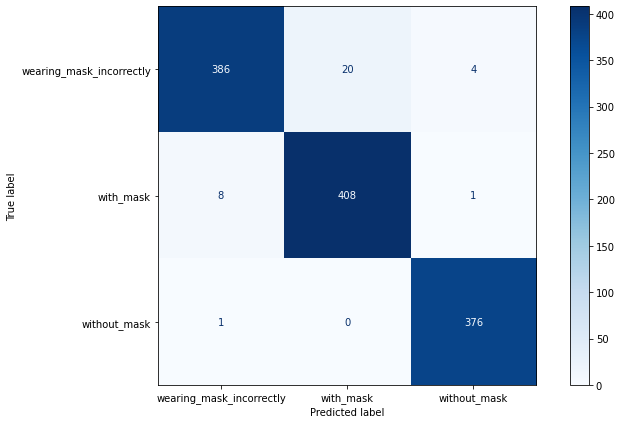

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

conf_mat = confusion_matrix(y_val.argmax(axis=1), predIdxs)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=cat)
disp.plot(cmap='Blues')
plt.tight_layout()
plt.style.use("ggplot")
plt.savefig('Confusion_matrix.png')

In [22]:
#save model in disk
model.save("face_mask_detector.model", save_format="h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


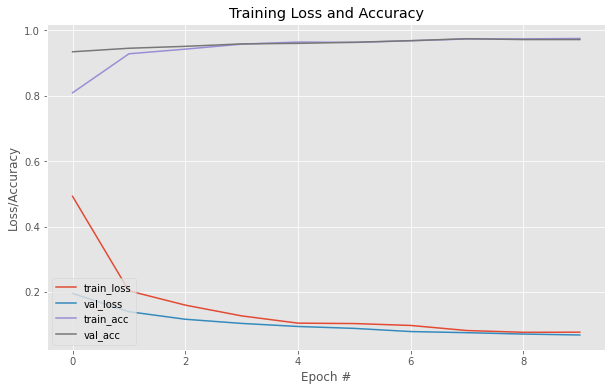

In [23]:
# plot the training loss and accuracy
N = ep_no
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")